In [2]:
import sys
sys.path.append("../scripts/")
from mcl import *
from scipy.stats import chi2

In [11]:
class KldMcl(Mcl):
    def __init__(self, envmap, init_pose, max_num, motion_noise_stds={"nn":0.19, "no": 0.001, "on":0.13, "oo": 0.2},
                distance_dev_rate=0.14, direction_dev=0.05,
                widths=np.array([0.2, 0.2, math.pi/18]).T, epsilon=0.1, delta=0.01):
        super().__init__(envmap, init_pose, 1, motion_noise_stds, distance_dev_rate, direction_dev)
        self.widths = widths
        self.max_num = max_num
        self.epsilon = epsilon
        self.delta = delta
        self.binnum = 0
        
    def motion_update(self, nu, omega, time):
        ws = [e.weight for e in self.particles]
        if sum(ws) < 1e-100:
            ws = [e + 1e-100 for e in ws]
            
        new_particles = []
        bins = set()
        for i in range(self.max_num):
            chosen_p = random.choices(self.particles, weights=ws)
            p = copy.deepcopy(chosen_p[0])
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            bins.add(tuple(math.floor(e) for e in p.pose/self.widths))
            new_particles.append(p)
            
            self.binnum = len(bins) if len(bins) > 1 else 2
            if len(new_particles) > math.ceil(chi2.ppf(1.0 - self.delta, self.binnum - 1)/(2*self.epsilon)):
                break
            
        self.particles = new_particles
        for i in range(len(self.particles)):
            self.particles[i].weight = 1.0/len(self.particles)
    
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
        
        self.set_ml()
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        elems.append(ax.text(-4.5, -4.5, "particle:{}, bin:{}".format(len(self.particles), self.binnum), fontsize=10))

<IPython.core.display.Javascript object>


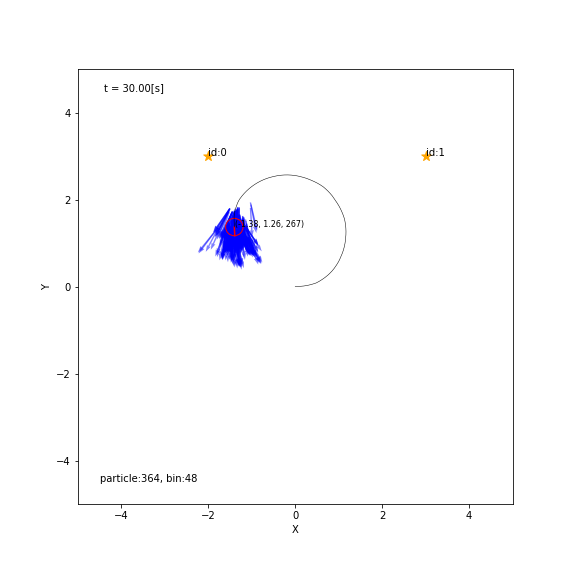

In [13]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    m = Map()
    for ln in [(-2, 3), (3, 3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)

    initial_pose = np.array([0, 0, 0]).T
    pf = KldMcl(m, initial_pose, 1000)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)
    
    world.draw()

trial()